In [1]:
from Poisson import autoencoder, equation
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
dataset = equation.Dataset('poisson')
dataset.load()
Phi_train, theta_train = dataset.train
Phi_val, theta_val = dataset.validate

In [3]:
model = autoencoder.fit(Phi_train, Phi_val, max_epochs=75)

Missing logger folder: lightning_logs/default
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


0



  | Name    | Type   | Params | In sizes | Out sizes
----------------------------------------------------------
0 | linear1 | Linear | 2 K    | [100]    | [20]     
1 | linear2 | Linear | 63     | [20]     | [3]      



Epoch 00000: val_checkpoint_on reached 1.44523 (best 1.44523), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=00|val_loss=1.45e+00.ckpt as top 1



Epoch 00001: val_checkpoint_on reached 0.15187 (best 0.15187), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=01|val_loss=1.52e-01.ckpt as top 1



Epoch 00002: val_checkpoint_on reached 0.00103 (best 0.00103), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=02|val_loss=1.03e-03.ckpt as top 1



Epoch 00003: val_checkpoint_on reached 0.00003 (best 0.00003), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=03|val_loss=3.27e-05.ckpt as top 1



Epoch 00004: val_checkpoint_on reached 0.00002 (best 0.00002), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=04|val_loss=1.54e-05.ckpt as top 1



Epoch 00005: val_checkpoint_on reached 0.00001 (best 0.00001), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=05|val_loss=7.16e-06.ckpt as top 1



Epoch 00006: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=06|val_loss=3.01e-06.ckpt as top 1



Epoch 00007: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=07|val_loss=1.16e-06.ckpt as top 1



Epoch 00008: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=08|val_loss=4.12e-07.ckpt as top 1



Epoch 00009: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=09|val_loss=1.36e-07.ckpt as top 1



Epoch 00010: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=10|val_loss=4.13e-08.ckpt as top 1



Epoch 00011: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=11|val_loss=1.16e-08.ckpt as top 1



Epoch 00012: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=12|val_loss=3.24e-09.ckpt as top 1



Epoch 00013: val_checkpoint_on  was not in top 1



Epoch 00014: val_checkpoint_on  was not in top 1



Epoch 00015: val_checkpoint_on  was not in top 1



Epoch 00016: val_checkpoint_on  was not in top 1



Epoch 00017: val_checkpoint_on  was not in top 1



Epoch 00018: val_checkpoint_on  was not in top 1



Epoch 00019: val_checkpoint_on  was not in top 1



Epoch 00020: val_checkpoint_on  was not in top 1



Epoch 00021: val_checkpoint_on  was not in top 1



Epoch 00022: val_checkpoint_on  was not in top 1



Epoch 00023: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=23|val_loss=2.80e-09.ckpt as top 1



Epoch 00024: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=24|val_loss=2.13e-10.ckpt as top 1



Epoch 00025: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=25|val_loss=2.85e-12.ckpt as top 1



Epoch 00026: val_checkpoint_on  was not in top 1



Epoch 00027: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=27|val_loss=8.94e-13.ckpt as top 1



Epoch 00028: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=28|val_loss=8.14e-13.ckpt as top 1



Epoch 00029: val_checkpoint_on  was not in top 1



Epoch 00030: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=30|val_loss=5.26e-13.ckpt as top 1



Epoch 00031: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=31|val_loss=5.25e-13.ckpt as top 1



Epoch 00032: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=32|val_loss=5.23e-13.ckpt as top 1



Epoch 00033: val_checkpoint_on  was not in top 1



Epoch 00034: val_checkpoint_on  was not in top 1



Epoch 00035: val_checkpoint_on  was not in top 1



Epoch 00036: val_checkpoint_on  was not in top 1



Epoch 00037: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=37|val_loss=5.22e-13.ckpt as top 1



Epoch 00038: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=38|val_loss=5.02e-13.ckpt as top 1



Epoch 00039: val_checkpoint_on  was not in top 1



Epoch 00040: val_checkpoint_on  was not in top 1



Epoch 00041: val_checkpoint_on  was not in top 1



Epoch 00042: val_checkpoint_on  was not in top 1



Epoch 00043: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=43|val_loss=5.00e-13.ckpt as top 1



Epoch 00044: val_checkpoint_on reached 0.00000 (best 0.00000), saving model to /Users/lukac/projects/IPDESA/lightning_logs/epoch=44|val_loss=4.96e-13.ckpt as top 1



Epoch 00045: val_checkpoint_on  was not in top 1



Epoch 00046: val_checkpoint_on  was not in top 1



Epoch 00047: val_checkpoint_on  was not in top 1



Epoch 00048: val_checkpoint_on  was not in top 1



Epoch 00049: val_checkpoint_on  was not in top 1



Epoch 00050: val_checkpoint_on  was not in top 1



Epoch 00051: val_checkpoint_on  was not in top 1



Epoch 00052: val_checkpoint_on  was not in top 1



Epoch 00053: val_checkpoint_on  was not in top 1



Epoch 00054: val_checkpoint_on  was not in top 1



Epoch 00055: val_checkpoint_on  was not in top 1



Epoch 00056: val_checkpoint_on  was not in top 1



Epoch 00057: val_checkpoint_on  was not in top 1



Epoch 00058: val_checkpoint_on  was not in top 1



Epoch 00059: val_checkpoint_on  was not in top 1



Epoch 00060: val_checkpoint_on  was not in top 1



Epoch 00061: val_checkpoint_on  was not in top 1



Epoch 00062: val_checkpoint_on  was not in top 1



Epoch 00063: val_checkpoint_on  was not in top 1



Epoch 00064: val_checkpoint_on  was not in top 1



Epoch 00065: val_checkpoint_on  was not in top 1



Epoch 00066: val_checkpoint_on  was not in top 1



Epoch 00067: val_checkpoint_on  was not in top 1



Epoch 00068: val_checkpoint_on  was not in top 1



Epoch 00069: val_checkpoint_on  was not in top 1



Epoch 00070: val_checkpoint_on  was not in top 1



Epoch 00071: val_checkpoint_on  was not in top 1



Epoch 00072: val_checkpoint_on  was not in top 1



Epoch 00073: val_checkpoint_on  was not in top 1



Epoch 00074: val_checkpoint_on  was not in top 1
Saving latest checkpoint..


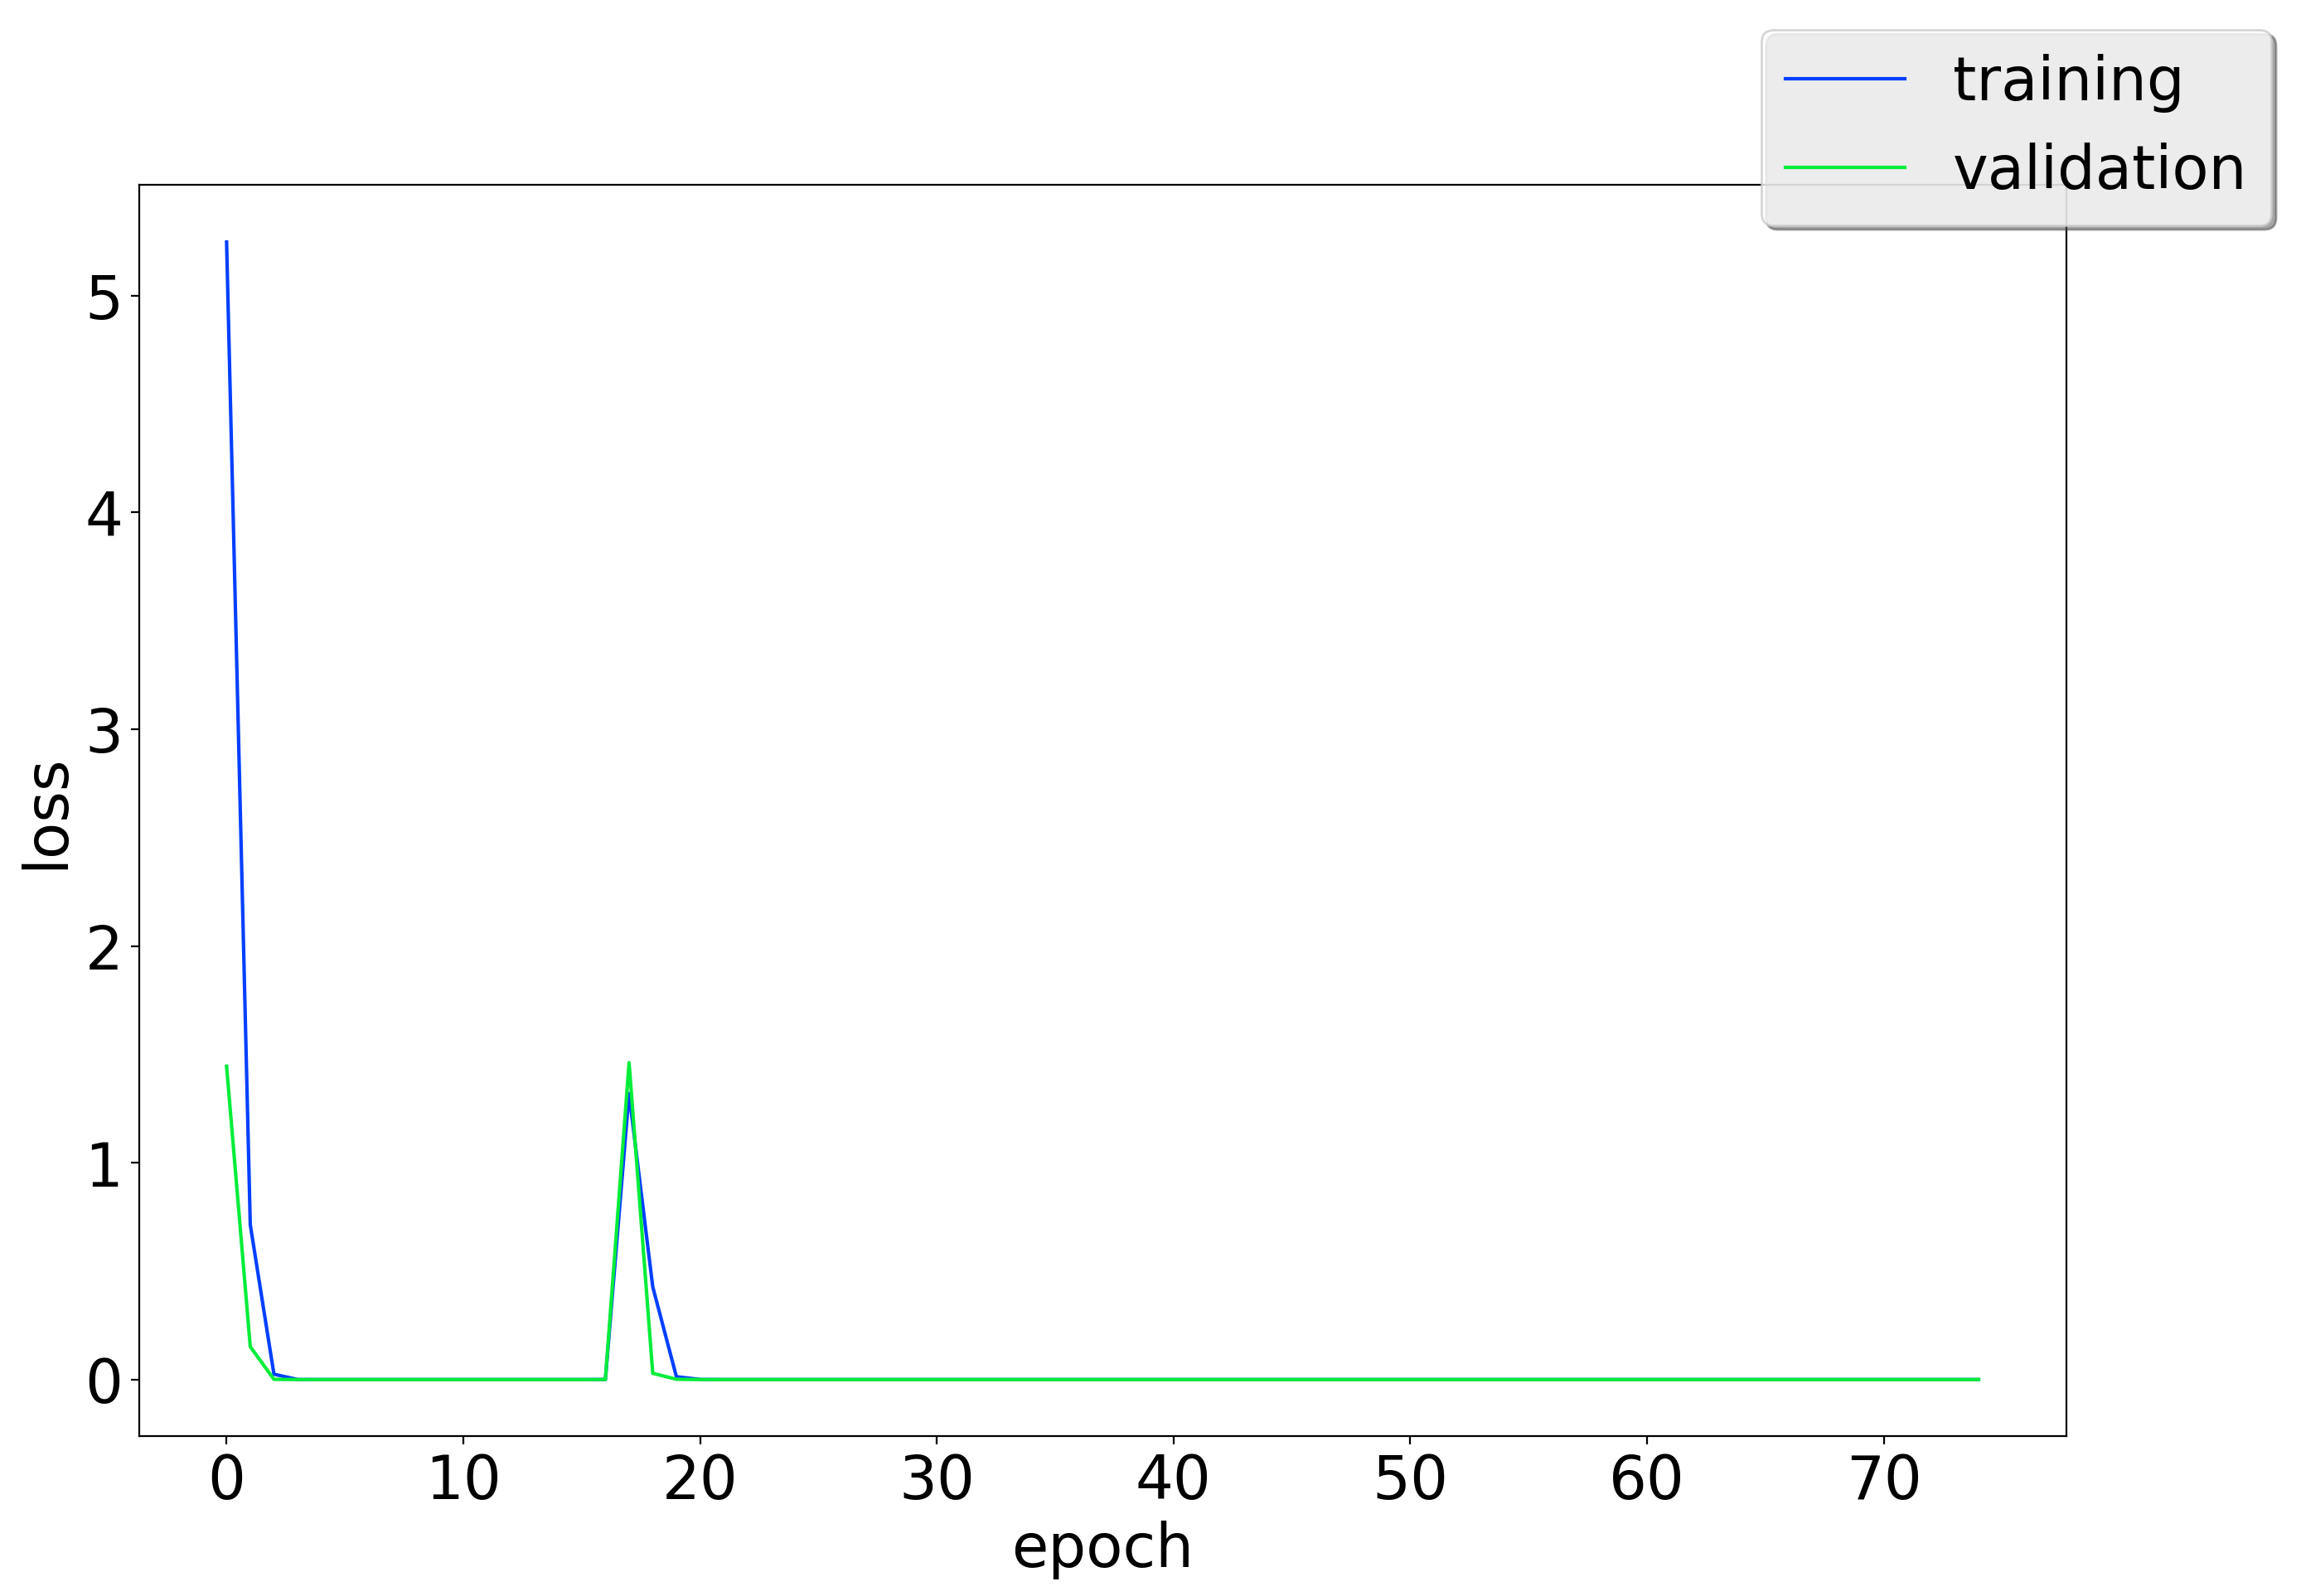

In [4]:
autoencoder.plot_loss(model)

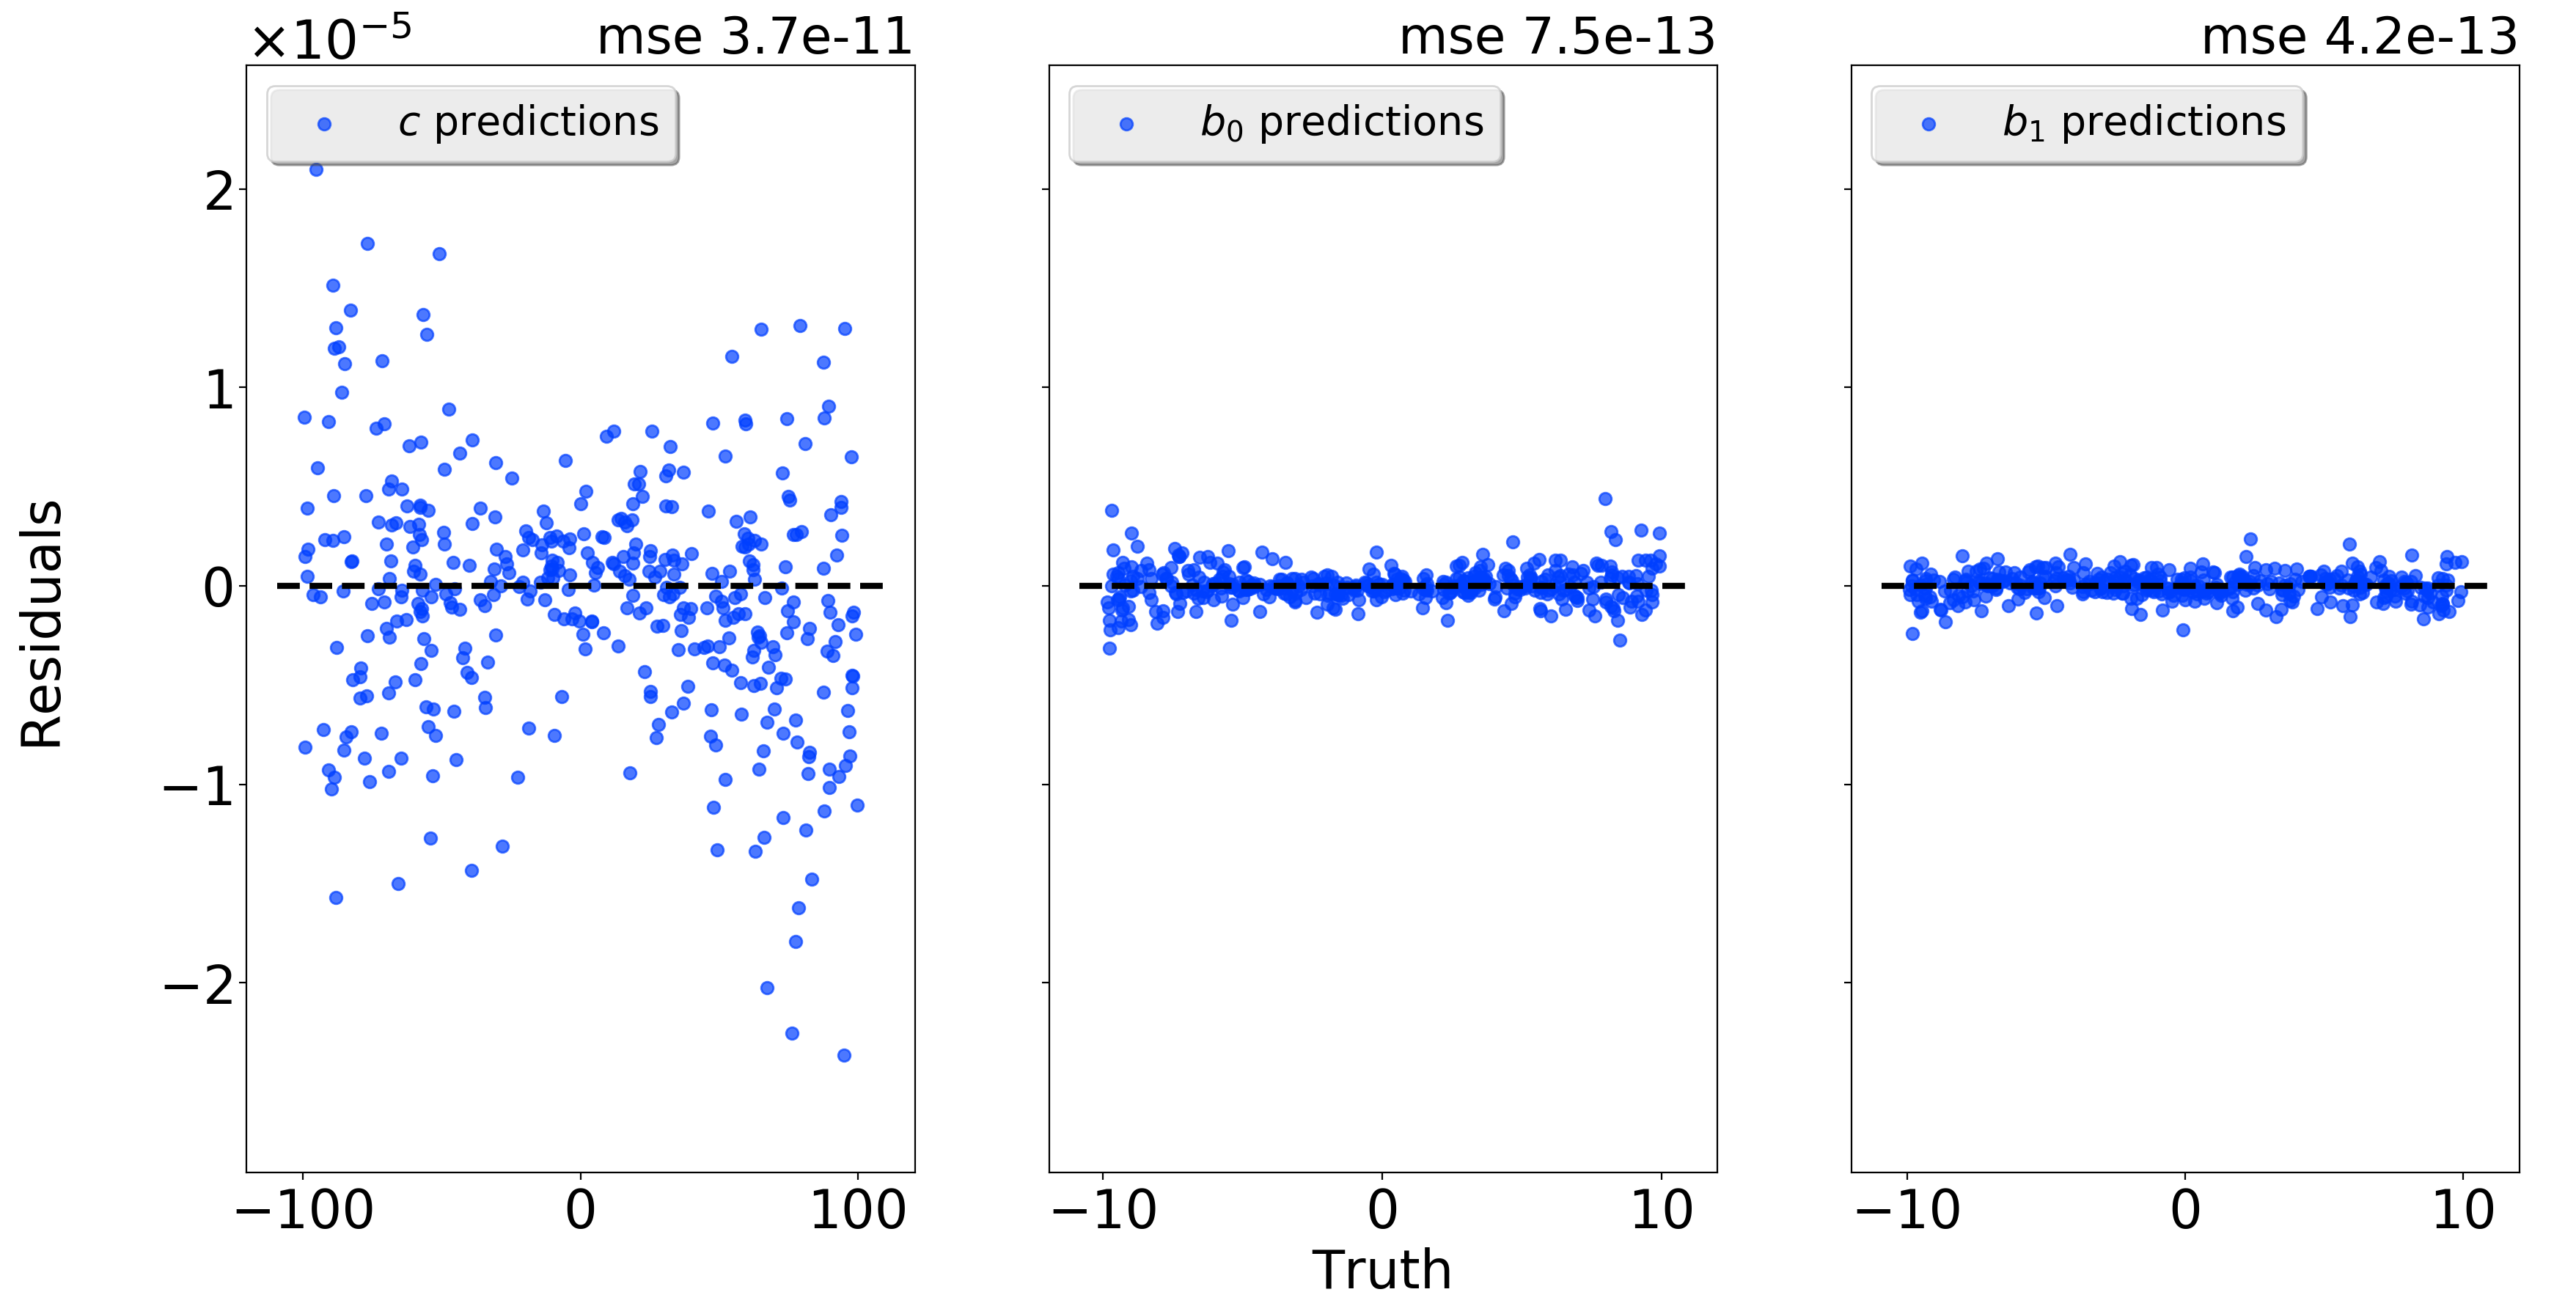

In [5]:
Phi_test, theta_test = dataset.test
autoencoder.plot_theta(model, Phi_test, theta_test)